In [10]:
!git clone https://github.com/PratyushTripathy/Landsat-Classification-Using-Neural-Network.git

Cloning into 'Landsat-Classification-Using-Neural-Network'...
remote: Enumerating objects: 46, done.
remote: Total 46 (delta 0), reused 0 (delta 0), pack-reused 46
Receiving objects: 100% (46/46), 41.16 MiB | 1.21 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [11]:
import numpy
import os
from pyrsgis import raster

os.chdir("/Users/roman_permyakov/Landsat_my_code/Source_img")
mxBangalore = 'l5_Bangalore2011_raw.tif' # source data
builtupBangalore = 'l5_Bangalore2011_builtup.tif' # source 0/1 raster coding urban areas with 1
mxHyderabad = 'l5_Hyderabad2011_raw.tif' # image to apply a future model for

# Read the rasters as array
ds1, featuresBangalore = raster.read(mxBangalore, bands='all')
ds2, labelBangalore = raster.read(builtupBangalore, bands=1)
ds3, featuresHyderabad = raster.read(mxHyderabad, bands='all')

print("Bangalore multispectral image shape: ", featuresBangalore.shape)
print("Bangalore binary built-up image shape: ", labelBangalore.shape)
print("Hyderabad multispectral image shape: ", featuresHyderabad.shape)

Bangalore multispectral image shape:  (6, 2054, 2044)
Bangalore binary built-up image shape:  (2054, 2044)
Hyderabad multispectral image shape:  (6, 1318, 1056)


In [12]:
# Convert the arrays to tables
from pyrsgis import convert

featuresBangalore = convert.array_to_table(featuresBangalore)
labelBangalore = convert.array_to_table(labelBangalore)
featuresHyderabad = convert.array_to_table(featuresHyderabad)
nBands = featuresBangalore.shape[1]
labelBangalore = (labelBangalore == 1).astype(int) # leave only (1) pixels to prevent issues with NoData (0) pixels 

print("Bangalore multispectral image shape: ", featuresBangalore.shape)
print("Bangalore binary built-up image shape: ", labelBangalore.shape)
print("Hyderabad multispectral image shape: ", featuresHyderabad.shape)

Bangalore multispectral image shape:  (4198376, 6)
Bangalore binary built-up image shape:  (4198376,)
Hyderabad multispectral image shape:  (1391808, 6)


In [13]:
# Split data into Training and Testing parts
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(featuresBangalore, labelBangalore, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(2519025, 6)
(2519025,)
(1679351, 6)
(1679351,)


In [14]:
# Normalise the data. Landsat data is a 8 bit -> 2^8 = 256 (0 - min, 255 - max)
xTrain = xTrain / 255.0
xTest = xTest / 255.0
featuresHyderabad = featuresHyderabad / 255.0

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresHyderabad = featuresHyderabad.reshape((featuresHyderabad.shape[0], 1, featuresHyderabad.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape, featuresHyderabad.shape)

(2519025, 1, 6) (1679351, 1, 6) (1391808, 1, 6)


In [15]:
# Build model with Keras (essential magic is here)
!pip install tensorflow #ML library 
from tensorflow import keras #Tensorflow interface

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)), #input layer
    keras.layers.Dense(14, activation='relu'), # hidden layer with 14 nodes
    keras.layers.Dense(2, activation='sigmoid')]) # similar to sigmoid function (to split on 0/1 values): 2 nodes

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [16]:
# Run the model
model.fit(xTrain, yTrain, epochs=3)

Epoch 1/3
78720/78720 [==============================] - 92s 1ms/step - loss: 0.1659 - accuracy: 0.9382
Epoch 2/3
78720/78720 [==============================] - 80s 1ms/step - loss: 0.1577 - accuracy: 0.9413
Epoch 3/3
78720/78720 [==============================] - 82s 1ms/step - loss: 0.1395 - accuracy: 0.9489


In [17]:
# Predict for test data and calculate accuracy metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[1457634   23242]
 [  58789  139686]]

P-Score: 0.857, R-Score: 0.704


In [18]:
# Predict for Hyderabad
predicted = model.predict(featuresHyderabad)
predicted = predicted[:,1]

#Export raster
prediction = numpy.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'Hyderabad_2011_BuiltupNN_predicted.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

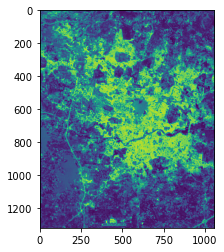

In [22]:
from skimage import io
import matplotlib.pyplot as plt

# read the image stack
img = io.imread('Hyderabad_2011_BuiltupNN_predicted.tif')
# show the image
plt.imshow(img)
#plt.imshow(img,cmap='gray')